# probfit Basic Tutorial

[probfit](http://iminuit.github.io/probfit/) is a modeling / fitting package to be used together with [iminuit](http://iminuit.github.com/iminuit/).

This tutorial is a fast-paced introduction to the probfit features:

* built-in common models: polynomial, gaussian, ...
* build-in common fit statistics: chi^2, binned and unbinned likelihood
* tools to get your fits to converge and check the results: try_uml, draw, draw_residuals, ...
* tools to help you implement your own models and fit statistics: Normalize, Extended, integrate_1d, ...

Please start this notebook with the ``ipython --pylab=inline`` option to get inline plots.

In [68]:
!pip install iminuit probfit cython

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [69]:
# We assume you have executed this cell in all the following examples
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import probfit
%matplotlib inline

In your own code you can explicitly import what you need to save
typing in interactive sessions, e.g.

    from iminuit import Minuit, describe
    from probfit import gaussian, BinnedLH

We don't do this here, we only import `iminuit` and `probfit` into our
namespace so that it is clear to you which functions and classes come
from which package while reading the code below.

## Chi^2 straight line fit

We can't really call this a fitting package without being able to fit a straight line, right?

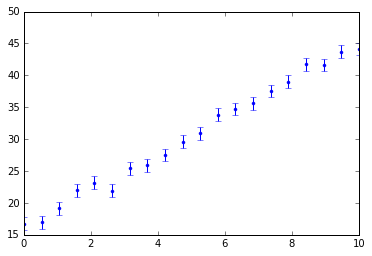

In [70]:
# Let's make a straight line with gaussian(mu=0, sigma=1) noise
np.random.seed(0)
x = np.linspace(0, 10, 20) 
y = 3 * x + 15 + np.random.randn(len(x))
err = np.ones(len(x))
plt.errorbar(x, y, err, fmt='.');

In [71]:
# Let's define our line.
# First argument has to be the independent variable,
# arguments after that are shape parameters.
def line(x, m, c): # define it to be parabolic or whatever you like
    return m * x + c

In [72]:
iminuit.describe(line)

['x', 'm', 'c']

In [73]:
# Define a chi^2 cost function
chi2 = probfit.Chi2Regression(line, x, y, err)

In [74]:
# Chi2Regression is just a callable object; nothing special about it
iminuit.describe(chi2)

['m', 'c']

In [75]:
# minimize it
# yes, it gives you a heads up that you didn't give it initial value
# we can ignore it for now
minuit = iminuit.Minuit(chi2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad(); # MIGRAD is a very stable robust minimization method
# you can look at your terminal to see what it is doing;

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter m does not have initial value. Assume 0.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter m is floating but does not have initial step size. Assume 1.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter c does not have initial value. Assume 0.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter c is floating but does not have initial step size. Assume 1.


FCN = 12.0738531135 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.10886029888e-21 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,m,2.88628,0.0736788,0,0,,,
2,c,16.1379,0.430946,0,0,,,


In [76]:
# The output above is a pretty-printed summary of the fit results from
# minuit.print_fmin()
# which was automatically called by iminuit.Minuit.migrad() after running MIGRAD.

# Let's see our results as Python dictionaries ...
print(minuit.values)
print(minuit.errors)

{'c': 16.137947520534624, 'm': 2.8862774144823855}
{'c': 0.4309458211385722, 'm': 0.07367884284273937}


#### Parabolic error
is calculated using the second derivative at the minimum
This is good in most cases where the uncertainty is symmetric not much correlation
exists. Migrad usually got this accurately but if you want ot be sure
call `minuit.hesse()` after calling `minuit.migrad()`.

#### Minos Error
is obtained by scanning the chi^2 or likelihood profile and find the point
where chi^2 is increased by `minuit.errordef`. Note that in the Minuit documentation
and output `errordef` is often called `up` ... it's the same thing.

#### What `errordef` should I use?

As explained in the Minuit documentation you should use:

* `errordef = 1` for chi^2 fits
* `errordef = 0.5` for likelihood fits

`errordef=1` is the default, so you only have to set it to `errordef=0.5`
if you are defining a likelihood cost function (if you don't your HESSE and MINOS errors will be incorrect).
`probfit` helps you by defining a `default_errordef()` attribute on the
cost function classes, which is automatically detected by the `Minuit` constructor
and can be used to set `Minuit.errordef` correctly, so that users can't forget.
Classes used in this tutorial:

* `probfit.Chi2Regression.get_errordef()` and `probfit.BinnedChi2.get_errordef()` return 1.
* `probfit.BinnedLH.get_errordef()` and `probfit.UnbinnedLH.get_errordef()` return 0.5.

((array([  0.        ,   0.52631579,   1.05263158,   1.57894737,
           2.10526316,   2.63157895,   3.15789474,   3.68421053,
           4.21052632,   4.73684211,   5.26315789,   5.78947368,
           6.31578947,   6.84210526,   7.36842105,   7.89473684,
           8.42105263,   8.94736842,   9.47368421,  10.        ]),
  array([ 16.76405235,  16.97910458,  19.13663272,  21.9777353 ,
          23.18334746,  21.91745896,  25.42377263,  25.90127437,
          27.5283601 ,  29.62112482,  30.93351726,  33.82269456,
          34.70840615,  35.64799081,  37.54912639,  39.01788485,
          41.75723697,  41.636947  ,  43.73412033,  44.14590426])),
 None,
 (array([  0.        ,   0.52631579,   1.05263158,   1.57894737,
           2.10526316,   2.63157895,   3.15789474,   3.68421053,
           4.21052632,   4.73684211,   5.26315789,   5.78947368,
           6.31578947,   6.84210526,   7.36842105,   7.89473684,
           8.42105263,   8.94736842,   9.47368421,  10.        ]),
  array([ 1

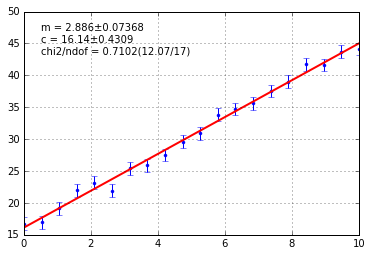

In [77]:
# Let's visualize our line
chi2.draw(minuit)
# looks good;

In [78]:
# Sometimes we want the error matrix (a.k.a. covariance matrix)
print('error matrix:')
print(minuit.matrix())
# or the correlation matrix
print('correlation matrix:')
print(minuit.matrix(correlation=True))
# or a pretty html representation
# Note that `print_matrix()` shows the correlation matrix, not the error matrix
minuit.print_matrix()

error matrix:
((0.005428571882645087, -0.027142859751431703), (-0.027142859751431703, 0.18571430075679826))
correlation matrix:
((1.0, -0.8548504260481388), (-0.8548504260481388, 1.0))


+,m,c
m,1.00,-0.85
c,-0.85,1.00


## Binned Poisson likelihood fit of a Gaussian distribution
In high energy physics, we usually want to fit a distribution to a histogram. Let's look at simple Gaussian distribution.

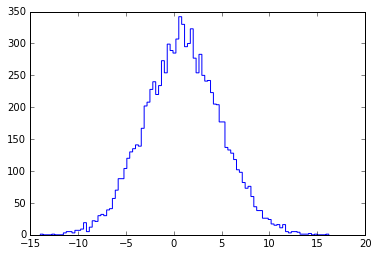

In [79]:
# First let's make some example data
np.random.seed(0)
data = np.random.randn(10000) * 4 + 1
# sigma = 4 and mean = 1
plt.hist(data, bins=100, histtype='step');

In [80]:
# Define your PDF / model
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

In [81]:
# Build your cost function
# Here we use binned likelihood
binned_likelihood = probfit.BinnedLH(gauss_pdf, data)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter mu does not have initial value. Assume 0.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()


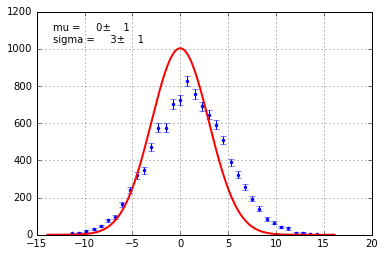

In [82]:
# Create the minuit
# and give an initial value for the sigma parameter
minuit = iminuit.Minuit(binned_likelihood, sigma=3)
# Remember: minuit.errordef is automatically set to 0.5
# as required for likelihood fits (this was explained above)
binned_likelihood.draw(minuit);

In [83]:
minuit.migrad()
# Like in all binned fit with long zero tail. It will have to do something about the zero bin
# probfit.BinnedLH does handle them gracefully but will give you a warning;

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: LogWarning: x is really small return 0
  if __name__ == '__main__':


FCN = 20.9368166553 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 1.45381812614e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,0.925875,0.039626,0,0,,,
2,sigma,3.95238,0.0282674,0,0,,,


({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 0.5, 'edm': 1.4538181261375696e-06, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 20.936816655253306, 'nfcn': 46},
 [{'is_const': False, 'name': 'mu', 'has_limits': False, 'value': 0.9258754454754967, 'number': 0, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.03962599040295913, 'is_fixed': False},
  {'is_const': False, 'name': 'sigma', 'has_limits': False, 'value': 3.952381323607855, 'number': 1, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.02826740732189662, 'is_fixed': False}])

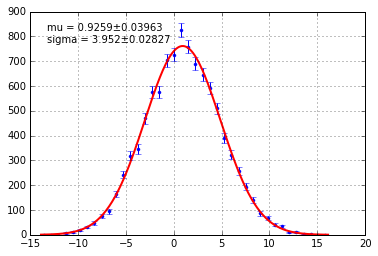

In [84]:
# Visually check if the fit succeeded by plotting the model over the data
binned_likelihood.draw(minuit); # uncertainty is given by symmetric Poisson;

In [85]:
# Let's see the result
print('Value: {}'.format(minuit.values))
print('Error: {}'.format(minuit.errors))

Value: {'mu': 0.9258754454754967, 'sigma': 3.952381323607855}
Error: {'mu': 0.03962599040295913, 'sigma': 0.02826740732189662}


In [86]:
# That printout can get out of hand quickly
minuit.print_fmin()
# Also print the correlation matrix
minuit.print_matrix()

FCN = 20.9368166553 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 1.45381812614e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,0.925875,0.039626,0,0,,,
2,sigma,3.95238,0.0282674,0,0,,,


+,mu,sigma
mu,1.00,-0.00
sigma,-0.00,1.00


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: LogWarning: x is really small return 0
  app.launch_new_instance()


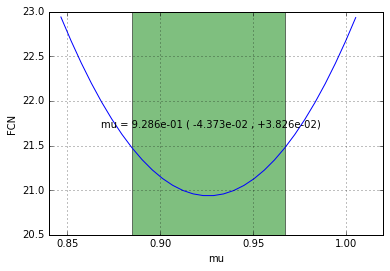

In [87]:
# Looking at a likelihood profile is a good method
# to check that the reported errors make sense
minuit.draw_mnprofile('mu');

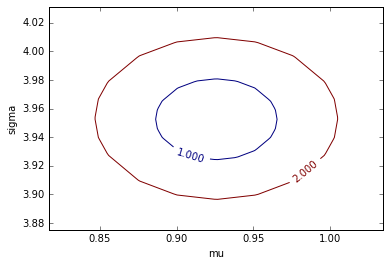

In [88]:
# Plot a 2d contour error
# You can notice that it takes some time to draw
# We will this is because our PDF is defined in Python
# We will show how to speed this up later
minuit.draw_mncontour('mu', 'sigma');

## Chi^2 fit of a Gaussian distribution

Let's explore another popular cost function chi^2.
Chi^2 is bad when you have bin with 0.
ROOT just ignore.
ROOFIT does something I don't remember.
But it's best to avoid using chi^2 when you have bin with 0 count.

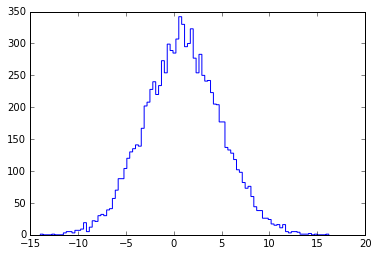

In [89]:
# We will use the same data as in the previous example
np.random.seed(0)
data = np.random.randn(10000) * 4 + 1
# sigma = 4 and mean = 1
plt.hist(data, bins=100, histtype='step');

In [90]:
# We will use the same PDF as in the previous example
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) **2 / 2. / sigma ** 2)

In [91]:
# Binned chi^2 fit only makes sense (for now) for extended PDFs
# probfit.Extended adds a norm parameter with name 'N'
extended_gauss_pdf = probfit.Extended(gauss_pdf)

In [92]:
# Describe the function signature
iminuit.describe(extended_gauss_pdf)

['x', 'mu', 'sigma', 'N']

In [93]:
# Chi^2 distribution fit is really bad for distribution with long tail
# since when bin count=0... poisson error=0 and blows up chi^2
# so give it some range
chi2 = probfit.BinnedChi2(extended_gauss_pdf, data, bound=(-7,10))
# This time we use the pedantic=False option to tell Minuit
# that we don't want warnings about parameters without initial
# value or step size.
# And print_level=0 means that no output is generated
minuit = iminuit.Minuit(chi2, sigma=1, pedantic=False, print_level=0)
minuit.migrad();

FCN = 36.5025998638 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 4.6474267658e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,0.906468,0.0448253,0,0,,,
2,sigma,3.95905,0.0411286,0,0,,,
3,N,9969.72,103.372,0,0,,,


+,mu,sigma,N
mu,1.00,-0.10,-0.05
sigma,-0.10,1.00,0.18
N,-0.05,0.18,1.00


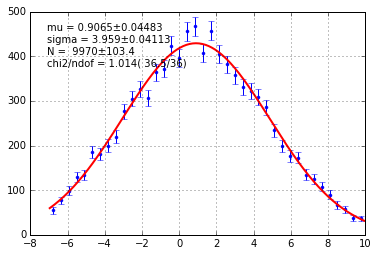

In [94]:
# Now let's look at the results
minuit.print_fmin()
minuit.print_matrix()
chi2.draw(minuit);

## Fast unbinned likelihood fit Cython

Unbinned likelihood is computationally very very expensive if you have a lot of data.
It's now a good time that we talk about how to speed things up with [Cython](http://cython.org).

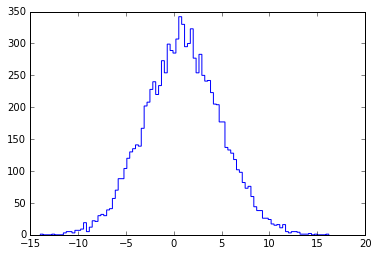

In [95]:
# We will use the same data as in the previous example
np.random.seed(0)
data = np.random.randn(10000) * 4 + 1
# sigma = 4 and mean = 1
plt.hist(data, bins=100, histtype='step');

In [96]:
# We want to speed things up with Cython
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [97]:
%%cython
# Same gaussian distribution but now written in Cython
# The %%cython IPython does the following:
# * Call Cython to generate C code for a Python C extension.
# * Compile it into a Python C extension (a shared library)
# * Load it into the current namespace
# If you don't understand these things, don't worry, it basically means:
# * Get full-metal speed easily
cimport cython
from libc.math cimport exp, M_PI, sqrt
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def gauss_pdf_cython(double x, double mu, double sigma):
    return 1 / sqrt(2 * M_PI) / sigma * exp(-(x - mu) ** 2 / 2. / sigma ** 2)

In [98]:
# Define the unbinned likelihood cost function 
unbinned_likelihood = probfit.UnbinnedLH(gauss_pdf_cython, data)

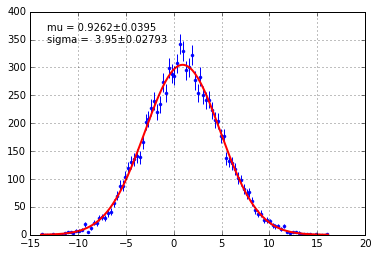

FCN = 27927.113951 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 3.94434184481e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,0.926222,0.039503,0,0,,,
2,sigma,3.9503,0.0279336,0,0,,,


+,mu,sigma
mu,1.00,0.00
sigma,0.00,1.00


In [99]:
minuit = iminuit.Minuit(unbinned_likelihood, sigma=2, pedantic=False, print_level=0)
# Remember: minuit.errordef is automatically set to 0.5
# as required for likelihood fits (this was explained above)
minuit.migrad() # yes: amazingly fast
unbinned_likelihood.show(minuit)
minuit.print_fmin()
minuit.print_matrix() 

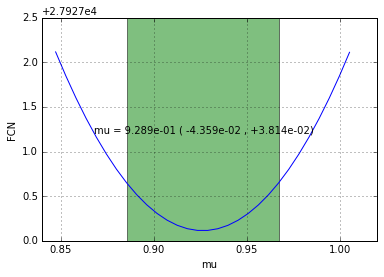

In [100]:
# Remember how slow draw_mnprofile() was in the last example?
# Now it's super fast (even though the unbinned
# likelihood computation is more compute-intensive).
minuit.draw_mnprofile('mu');

But you really don't have to write your own gaussian, there are tons of builtin functions written in Cython for you.

In [101]:
# Here's how you can list them
import probfit.pdf
print(dir(probfit.pdf))
print(iminuit.describe(probfit.pdf.gaussian))
print(type(probfit.pdf.gaussian))
# But actually they are always all imported into the main probfit
# namespace, so we'll keep using the simpler probfit.gaussian instead of
# probfit.pdf.gaussian here.

['HistogramPdf', 'MinimalFuncCode', 'Polynomial', '_Linear', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '__pyx_capi__', '__test__', 'argus', 'cauchy', 'cruijff', 'crystalball', 'describe', 'doublegaussian', 'gaussian', 'linear', 'novosibirsk', 'np', 'poly2', 'poly3', 'rtv_breitwigner', 'ugaussian']
[u'x', u'mean', u'sigma']
<type 'builtin_function_or_method'>


FCN = 27927.113951 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 3.94434240024e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mean,0.926222,0.039503,0,0,,,
2,sigma,3.9503,0.0279336,0,0,,,


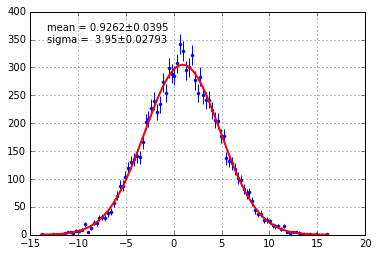

In [102]:
unbinned_likelihood = probfit.UnbinnedLH(probfit.gaussian, data)
minuit = iminuit.Minuit(unbinned_likelihood, sigma=2, pedantic=False)
# Remember: minuit.errordef is automatically set to 0.5
# as required for likelihood fits (this was explained above)
minuit.migrad() # yes: amazingly fast
unbinned_likelihood.draw(minuit, show_errbars='normal'); # control how fit is displayed too;

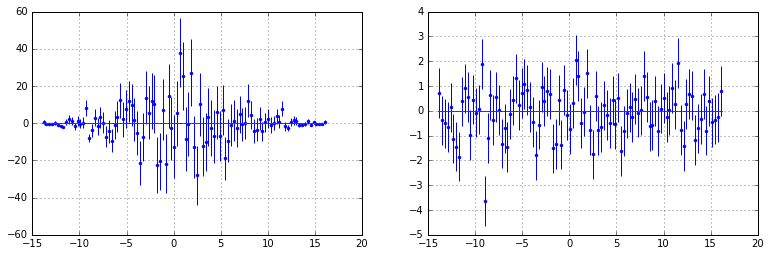

In [103]:
# Draw the difference between data and PDF
plt.figure(figsize=(13,4))
plt.subplot(121)
unbinned_likelihood.draw_residual(minuit)
plt.subplot(122)
unbinned_likelihood.draw_residual(minuit, show_errbars=True, errbar_algo='sumw2', norm=True)

##But... We can't normalize everything analytically and how to generate toy sample from PDF

When fitting distribution to a PDF, one of the common problem that we run into is normalization.
Not all function is analytically integrable on the range of our interest.

Let's look at an example: the [Crystal Ball function](http://en.wikipedia.org/wiki/Crystal_Ball_function).
It's simply a gaussian with a power law tail ... normally found in energy deposited in crystals ...
impossible to normalize analytically and normalization will depend on shape parameters.

[u'x', u'alpha', u'n', u'mean', u'sigma']


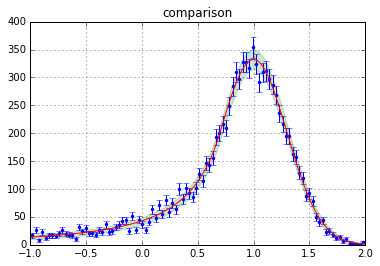

In [104]:
np.random.seed(0)
bound = (-1, 2)
data = probfit.gen_toy(probfit.crystalball, 10000, bound=bound, alpha=1., n=2., mean=1., sigma=0.3, quiet=False)
# quiet=False tells gen_toy to plot out original function
# toy histogram and poisson error from both orignal distribution and toy

In [105]:
# To fit this function as a distribution we need to normalize
# so that is becomes a PDF ober the range we consider here.
# We do this with the probfit.Normalized functor, which implements
# the trapezoid numerical integration method with a simple cache mechanism
normalized_crystalball = probfit.Normalized(probfit.crystalball, bound)
# this can also bedone with decorator
# @probfit.normalized(bound)
# def my_function(x, blah):
#    return something
pars = 1.0, 1, 2, 1, 0.3
print('function: {}'.format(probfit.crystalball(*pars)))
print('     pdf: {}'.format(normalized_crystalball(*pars)))

function: 1.0
     pdf: 1.10945669814


In [106]:
# The normalized version has the same signature as the non-normalized version
print(iminuit.describe(probfit.crystalball))
print(iminuit.describe(normalized_crystalball))

[u'x', u'alpha', u'n', u'mean', u'sigma']
[u'x', u'alpha', u'n', u'mean', u'sigma']


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter alpha is floating but does not have initial step size. Assume 1.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter n is floating but does not have initial step size. Assume 1.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SmallIntegralWarning: (0.9689428295957161, 0.44086027281289175, -7.852819454184058, 0.9263111214440007, 0.29811644525305303)


FCN = 6154.37579109 
 TOTAL NCALL = 178 
 NCALLS = 178 
 
 
 EDM = 1.09346528365e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,alpha,1.01296,0.0532174,0,0,,,
2,n,1.81276,0.217714,0,0,,,
3,mean,0.998247,0.00558393,0,0,,,
4,sigma,0.299661,0.00419534,0,0,,,


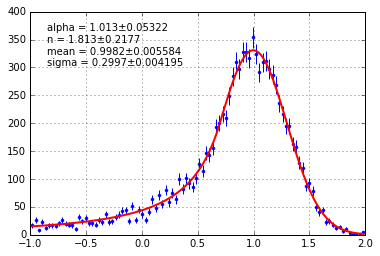

In [107]:
# We can fit the normalized function in the usual way ...
unbinned_likelihood = probfit.UnbinnedLH(normalized_crystalball, data)
start_pars = dict(alpha=1, n=2.1, mean=1.2, sigma=0.3)
minuit = iminuit.Minuit(unbinned_likelihood, **start_pars)
# Remember: minuit.errordef is automatically set to 0.5
# as required for likelihood fits (this was explained above)
minuit.migrad() # yes: amazingly fast Normalize is written in Cython
unbinned_likelihood.show(minuit);
# The Crystal Ball function is notorious for its sensitivity on the 'n' parameter
# probfit give you a heads up where it might have float overflow;

## But what if I know the analytical integral formula for my distribution?

`probfit` checks for a method called `integrate` with the signature `integrate(bound, nint, *arg)` to
compute definite integrals for given `bound` and `nint` (pieces of integral this is normally ignored)
and the rest will be passed as positional argument.

For some `probfit` built-in distributions analytical formulae have been implemented.

In [108]:
def line(x, m, c):
    return m * x + c

# compute integral of line from x=(0,1) using 10 intevals with m=1. and c=2.
# all probfit internal use this
# no integrate method available probfit use simpson3/8
print(probfit.integrate1d(line, (0, 1), 10, (1., 2.)))

# Let us illustrate the point by forcing it to have integral that's off by
# factor of two
def wrong_line_integrate(bound, nint, m, c):
    a, b = bound
    # I know this is wrong:
    return 2 * (m * (b ** 2 / 2. - a ** 2 / 2.) + c * (b - a))

line.integrate = wrong_line_integrate
# line.integrate = lambda bound, nint, m, c: blah blah # this works too
print(probfit.integrate1d(line, (0, 1), 10, (1., 2.)))

2.5
5.0


## What if things go wrong?

In this section we show you what happens when your distribution doesn't fit and how you can make it.

We again use the Crystal Ball distribution as an example, which is notoriously sensitive to initial parameter values.

In [109]:
unbinned_likelihood = probfit.UnbinnedLH(normalized_crystalball, data)
# No initial values given -> all parameters have default initial value 0
minuit = iminuit.Minuit(unbinned_likelihood)
# Remember: minuit.errordef is automatically set to 0.5
# as required for likelihood fits (this was explained above)
minuit.migrad() # yes: amazingly fast but tons of output on the console
# Remember there is a heads up;

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter alpha does not have initial value. Assume 0.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter alpha is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter n does not have initial value. Assume 0.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter n is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter mean does not have initial value. Assume 0.
  app.launch_new_instance()
/root/miniconda/envs/rep_py2/lib/python

FCN = 10986.1228867 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 0.0 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,alpha,0,1,0,0,,,
2,n,0,1,0,0,,,
3,mean,0,1,0,0,,,
4,sigma,0,1,0,0,,,


({'hesse_failed': True, 'has_reached_call_limit': False, 'has_accurate_covar': False, 'has_posdef_covar': False, 'up': 0.5, 'edm': 0.0, 'is_valid': False, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 10986.122886679714, 'nfcn': 28},
 [{'is_const': False, 'name': 'alpha', 'has_limits': False, 'value': 0.0, 'number': 0, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 1.0, 'is_fixed': False},
  {'is_const': False, 'name': 'n', 'has_limits': False, 'value': 0.0, 'number': 1, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 1.0, 'is_fixed': False},
  {'is_const': False, 'name': 'mean', 'has_limits': False, 'value': 0.0, 'number': 2, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 1.0, 'is_fixed': False},
  {'is_const': False, 'name': 'sigma', 'has_limits': Fals

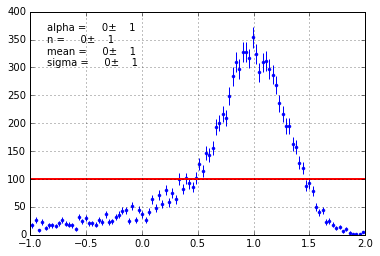

In [110]:
# This shows that we failed.
# The parameters are still at the default initial values
unbinned_likelihood.show(minuit);

In [111]:
# These two status flags tell you if the best-fit parameter values
# and the covariance matrix (the parameter errors) are OK.
print(minuit.migrad_ok())
print(minuit.matrix_accurate())

False
False


To make MIGRAD converge we need start parameter values that are roughly correct. Remember that above the same fit converged when we used ::

    start_pars = dict(alpha=1, n=2.1, mean=1.2, sigma=0.3)
    minuit = iminuit.Minuit(unbinned_likelihood, **start_pars)
    
#### But how can we guess these initial values?

This is a hard question that doesn't have one simple answer. Visualizing your data and model helps.


{u'alpha': 1.0, u'mean': 1.2, u'sigma': 0.3, u'n': 2.1}


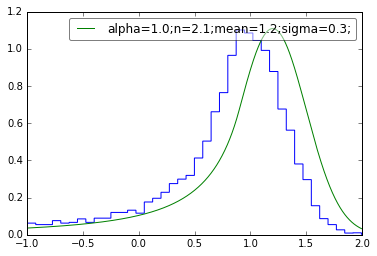

In [112]:
# Try one set of parameters
best_try = probfit.try_uml(normalized_crystalball, data, alpha=1., n=2.1, mean=1.2, sigma=0.3)
print(best_try)

{u'alpha': 1.0, u'mean': 1.1, u'sigma': 0.3, u'n': 2.1}


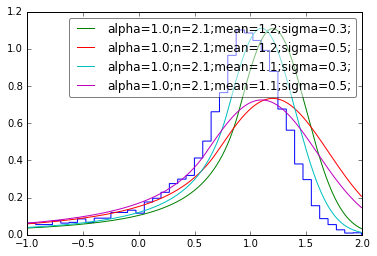

In [113]:
# Or try multiple sets of parameters
# (too many will just confuse you)
best_try = probfit.try_uml(normalized_crystalball, data, alpha=1., n=2.1, mean=[1.2, 1.1], sigma=[0.3, 0.5])
# try_uml computes the unbinned likelihood for each set of parameters and returns the best
# one as a dictionary.
# This is actually a poor-man's optimization algorithm in itself called grid search
# which is popular to find good start values for other, faster optimization methods like MIGRAD.
print(best_try)

## Extended fit: two Gaussians with polynomial background

Here we show how to create and fit a model that is the sum of several other models.

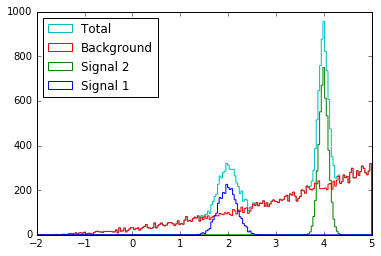

In [114]:
# Generate some example data
np.random.seed(0)
data_peak1 = np.random.randn(3000) * 0.2 + 2
data_peak2 = np.random.randn(5000) * 0.1 + 4
data_range = (-2, 5)
data_bg = probfit.gen_toy(lambda x : 4 + 4 * x + x ** 2, 20000, data_range)
data_all = np.concatenate([data_peak1, data_peak2, data_bg])
plt.hist((data_peak1, data_peak2, data_bg, data_all),
         label=['Signal 1', 'Signal 2', 'Background', 'Total'],
         bins=200, histtype='step', range=data_range)
plt.legend(loc='upper left');

In [115]:
# Using a polynomial to fit a distribution is problematic, because the
# polynomial can assume negative values, which results in NaN (not a number)
# values in the likelihood function.
# To avoid this problem we restrict the fit to the range (0, 5) where
# the polynomial is clearly positive.
fit_range = (0, 5)
normalized_poly = probfit.Normalized(probfit.Polynomial(2), fit_range)
normalized_poly = probfit.Extended(normalized_poly, extname='NBkg')

gauss1 = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu1', 'sigma1']), extname='N1')
gauss2 = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu2', 'sigma2']), extname='N2')

# Define an extended PDF consisting of three components
pdf = probfit.AddPdf(normalized_poly, gauss1, gauss2)

print('normalized_poly: {}'.format(probfit.describe(normalized_poly)))
print('gauss1:          {}'.format(probfit.describe(gauss1)))
print('gauss2:          {}'.format(probfit.describe(gauss2)))
print('pdf:             {}'.format(probfit.describe(pdf)))

normalized_poly: ['x', 'c_0', 'c_1', 'c_2', 'NBkg']
gauss1:          ['x', 'mu1', 'sigma1', 'N1']
gauss2:          ['x', 'mu2', 'sigma2', 'N2']
pdf:             ['x', 'c_0', 'c_1', 'c_2', 'NBkg', 'mu1', 'sigma1', 'N1', 'mu2', 'sigma2', 'N2']


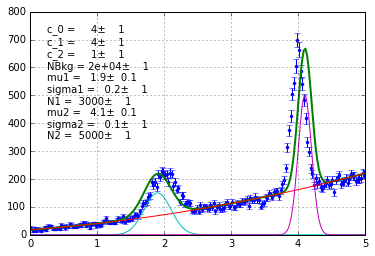

In [116]:
# Define the cost function in the usual way ...
binned_likelihood = probfit.BinnedLH(pdf, data_all, bins=200, extended=True, bound=fit_range)

# This is a quite complex fit (11 free parameters!), so we need good starting values.
# Actually we even need to set an initial parameter error
# for 'mu1' and 'mu2' to make MIGRAD converge.
# The initial parameter error is used as the initial step size in the minimization.
pars = dict(mu1=1.9, error_mu1=0.1, sigma1=0.2, N1=3000,
            mu2=4.1, error_mu2=0.1, sigma2=0.1, N2=5000,
            c_0=4, c_1=4, c_2=1, NBkg=20000)
minuit = iminuit.Minuit(binned_likelihood, pedantic=False, print_level=0, **pars)
# You can see that the model already roughly matches the data
binned_likelihood.draw(minuit, parts=True);

In [117]:
# This can take a while ... the likelihood is evaluated a few 100 times
# (and each time the distributions are evaluated, including the
# numerical computation of the normalizing integrals)
minuit.migrad();

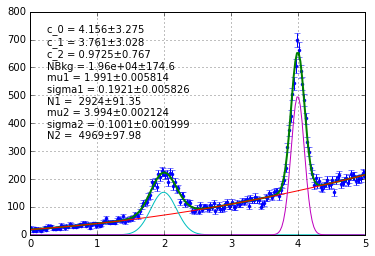

FCN = 88.5482069321 
 TOTAL NCALL = 331 
 NCALLS = 331 
 
 
 EDM = 2.50658883904e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c_0,4.1565,3.27518,0,0,,,
2,c_1,3.7613,3.02813,0,0,,,
3,c_2,0.972491,0.766978,0,0,,,
4,NBkg,19601.2,174.571,0,0,,,
5,mu1,1.99082,0.00581367,0,0,,,
6,sigma1,0.19211,0.00582561,0,0,,,
7,N1,2923.54,91.3543,0,0,,,
8,mu2,3.99415,0.00212376,0,0,,,
9,sigma2,0.10011,0.00199943,0,0,,,
10,N2,4969.16,97.9753,0,0,,,


+,c_0,c_1,c_2,NBkg,mu1,sigma1,N1,mu2,sigma2,N2
c_0,1.00,0.98,1.00,0.00,0.00,-0.01,-0.01,0.00,0.00,0.00
c_1,0.98,1.00,0.97,0.04,-0.01,-0.06,-0.09,0.01,0.00,0.01
c_2,1.00,0.97,1.00,-0.01,-0.00,0.02,0.02,-0.00,-0.01,-0.01
NBkg,0.00,0.04,-0.01,1.00,-0.05,-0.28,-0.37,-0.01,-0.23,-0.30
mu1,0.00,-0.01,-0.00,-0.05,1.00,0.08,0.07,0.00,0.02,0.02
sigma1,-0.01,-0.06,0.02,-0.28,0.08,1.00,0.50,-0.02,0.03,0.04
N1,-0.01,-0.09,0.02,-0.37,0.07,0.50,1.00,-0.02,0.04,0.05
mu2,0.00,0.01,-0.00,-0.01,0.00,-0.02,-0.02,1.00,0.03,0.03
sigma2,0.00,0.00,-0.01,-0.23,0.02,0.03,0.04,0.03,1.00,0.38
N2,0.00,0.01,-0.01,-0.30,0.02,0.04,0.05,0.03,0.38,1.00


In [118]:
binned_likelihood.show(minuit, parts=True);
minuit.print_fmin()
minuit.print_matrix()

Note the red upper left corner in the correlation matrix above?

It shows that the three polynomial parameters `c_0`, `c_1` and `c_2` are highly correlated?
The reason is that we put a constraint on the polynomial to be normalized over the fit range:

    fit_range = (0, 5)
    normalized_poly = probfit.Normalized(probfit.Polynomial(2), fit_range)
    normalized_poly = probfit.Extended(normalized_poly, extname='NBkg')

To resolve this problem you could simply use a non-normalized and non-extended polynomial to model the background. We won't do this here, though ...

## Custom Drawing

The `draw()` and `show()` method we provide is intended to just give you a quick look at your fit.

To make a custom drawing you can use the return value of `draw()` and `show()`.

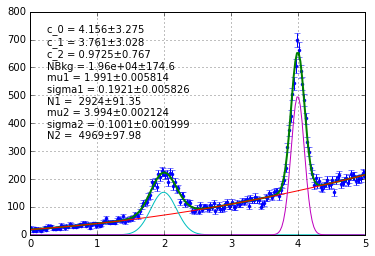

In [119]:
# You should copy & paste the return tuple from the `draw` docstring ...
((data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y), parts) = binned_likelihood.draw(minuit, parts=True);
# ... now we have everything to make our own plot

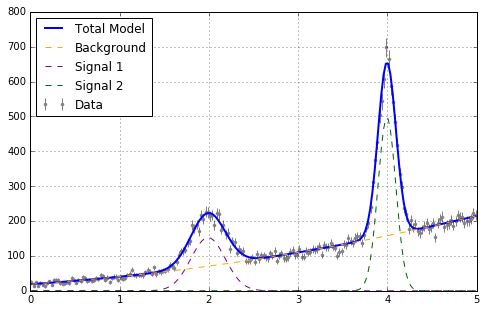

In [120]:
# Now make the plot as pretty as you like, e.g. with matplotlib.
plt.figure(figsize=(8, 5))
plt.errorbar(probfit.mid(data_edges), datay, errorp, fmt='.', capsize=0, color='Gray', label='Data')
plt.plot(total_pdf_x, total_pdf_y, color='blue', lw=2, label='Total Model')
colors = ['orange', 'purple', 'DarkGreen']
labels = ['Background', 'Signal 1', 'Signal 2']
for color, label, part in zip(colors, labels, parts):
    x, y = part
    plt.plot(x, y, ls='--', color=color, label=label)
plt.grid(True)
plt.legend(loc='upper left');

## Simultaneous fit to several data sets

Sometimes, what we want to fit is the sum of likelihood /chi^2 of two PDFs for two different datasets that share some parameters.

In this example, we will fit two Gaussian distributions where we know that the widths are the same
but the peaks are at different places.

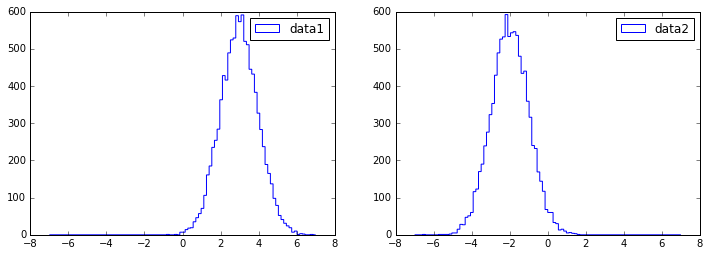

In [121]:
# Generate some example data
np.random.seed(0)
data1 = np.random.randn(10000) + 3 # mean =  3, sigma = 1
data2 = np.random.randn(10000) - 2 # mean = -2, sigma = 1
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(data1, bins=100, range=(-7, 7), histtype='step', label='data1')
plt.legend()
plt.subplot(122)
plt.hist(data2, bins=100, range=(-7, 7), histtype='step', label='data2')
plt.legend();

In [122]:
# There is nothing special about built-in cost function
# except some utility function like draw and show
likelihood1 = probfit.UnbinnedLH(probfit.rename(probfit.gaussian, ('x', 'mean2', 'sigma')), data1)
likelihood2 = probfit.UnbinnedLH(probfit.gaussian, data2)
simultaneous_likelihood = probfit.SimultaneousFit(likelihood1, likelihood2)
print(probfit.describe(likelihood1))
print(probfit.describe(likelihood2))
# Note that the simultaneous likelihood has only 3 parameters, because the
# 'sigma' parameter is tied (i.e. linked to always be the same).
print(probfit.describe(simultaneous_likelihood))

['mean2', 'sigma']
[u'mean', u'sigma']
['mean2', 'sigma', u'mean']


In [123]:
# Ah, the beauty of Minuit ... it doesn't care what your cost funtion is ...
# you can use it to fit (i.e. compute optimal parameters and parameter errors) anything.
minuit = iminuit.Minuit(simultaneous_likelihood, sigma=0.5, pedantic=False, print_level=0)
# Well, there's one thing we have to tell Minuit so that it can compute parameter errors,
# and that is the value of `errordef`, a.k.a. `up` (explained above).
# This is a likelihood fit, so we need `errordef = 0.5` and not the default `errordef = 1`:
minuit.errordef = 0.5

In [124]:
# Run the fit and print the results
minuit.migrad();
minuit.print_fmin()
minuit.print_matrix()

FCN = 28184.0142939 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 6.2598832354e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mean2,2.98154,0.00990303,0,0,,,
2,sigma,0.990302,0.00495146,0,0,,,
3,mean,-1.98899,0.00990303,0,0,,,


+,mean2,sigma,mean
mean2,1.00,0.00,0.00
sigma,0.00,1.00,0.00
mean,0.00,0.00,1.00


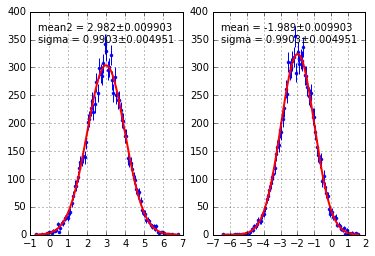

In [125]:
simultaneous_likelihood.draw(minuit);

## Blinding parameters

Often, an analyst would like to avoid looking at the result of the fitted parameter(s) before he/she finalized the analysis in order to avoid biases due to the prejudice of the analyst. Probfit provids a transformation function that hides the true value(s) of the parameter(s). The transformation function requires a string to set the seed of the random number generator, and a scale to smear the parameter(s) using a Gaussian.

In [126]:
from probfit import UnbinnedLH, BlindFunc, rename, AddPdfNorm
from probfit import gaussian
from iminuit import Minuit, describe
from probfit import gen_toy

In [127]:
g0= rename(gaussian, ['x', 'm0', 's0'])
g1= rename(gaussian, ['x', 'm1', 's1'])
pdf= AddPdfNorm(g0,g1)

describe(pdf)

['x', 'm0', 's0', 'm1', 's1', 'f_0']

['x', 'm0', 's0', 'm1', 's1', 'f_0']


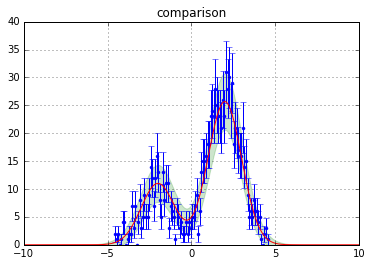

In [128]:
import random
random.seed(0)
toydata = gen_toy(pdf, 1000,(-10,10), m0=-2, m1=2, s0=1, s1=1, f_0=0.3, quiet=False)

In [129]:
inipars= dict(m0=0, m1=0, s0=1, s1=1, f_0=0.5, error_m0=0.1, error_m1=0.1, error_s0=0.1, error_s1=0.1, error_f_0=0.1)

FCN = 1925.44109076 
 TOTAL NCALL = 193 
 NCALLS = 193 
 
 
 EDM = 1.20475372247e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,m0,1.97468,0.0388865,0,0,,,
2,s0,0.976922,0.0298306,0,0,,,
3,m1,-2.1619,0.0692919,0,0,,,
4,s1,0.945974,0.0535416,0,0,,,
5,f_0,0.740277,0.0147095,0,0,,,


{'f_0': 0.7402773346995878, 's1': 0.9459743634057162, 's0': 0.9769218599704339, 'm1': -2.1618999251568485, 'm0': 1.974678638292248}


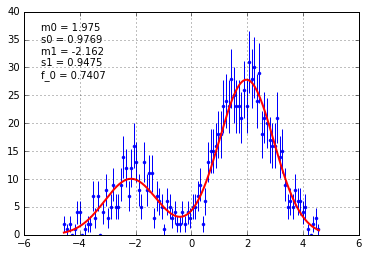

In [130]:
# Normal fit
uh1= UnbinnedLH(pdf, toydata)
m1= Minuit(uh1, print_level=1, **inipars)
m1.migrad();
uh1.draw();
print m1.values

FCN = 1925.44109332 
 TOTAL NCALL = 192 
 NCALLS = 192 
 
 
 EDM = 1.46269144888e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,m0,1.97466,0.0388888,0,0,,,
2,s0,0.976966,0.0298345,0,0,,,
3,m1,-2.18973,0.0692999,0,0,,,
4,s1,0.945833,0.0535263,0,0,,,
5,f_0,0.74028,0.0147096,0,0,,,


{'f_0': 0.7402795164411778, 's1': 0.9458325026423022, 's0': 0.976965980845707, 'm1': -2.189733211861824, 'm0': 1.9746571809313913}


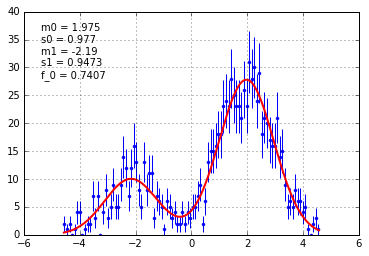

In [131]:
# Blind one parameter
uh2= UnbinnedLH( BlindFunc(pdf, toblind='m1', seedstring='some_random_stuff', width=0.5, signflip=False), toydata)
m2= Minuit(uh2, print_level=1, **inipars)
m2.migrad();
uh2.draw();
print m2.values

In [132]:
print m1.values
print m2.values
print
print m1.errors
print m2.errors

{'f_0': 0.7402773346995878, 's1': 0.9459743634057162, 's0': 0.9769218599704339, 'm1': -2.1618999251568485, 'm0': 1.974678638292248}
{'f_0': 0.7402795164411778, 's1': 0.9458325026423022, 's0': 0.976965980845707, 'm1': -2.189733211861824, 'm0': 1.9746571809313913}

{'f_0': 0.01470948988328952, 's1': 0.05354160590258055, 's0': 0.029830612946265395, 'm1': 0.06929186993967475, 'm0': 0.03888650450017257}
{'f_0': 0.014709558114162389, 's1': 0.053526346398147455, 's0': 0.029834484776138325, 'm1': 0.06929994962772118, 'm0': 0.03888884625869945}


In [133]:
print m2.values['m0']-m1.values['m0']

-2.14573608568e-05


In [134]:
# Now it's your turn ...
# try and apply probfit / iminuit and to your modeling / fitting task! 